In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

Let's pick and load a pretrained model! 
Or build your own, save as .h5 file, load!

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')

# pretrained_model = tf.keras.applications.resnet50.ResNet50(include_top=True,
#                                                      weights='imagenet')

# pretrained_model = tf.keras.applications.inception_v3.InceptionV3(include_top=True,
#                                                                   weights='imagenet')

# pretrained_model = tf.keras.applications.nasnet.NASNetMobile(include_top=True,
#                                                              weights='imagenet')

pretrained_model.trainable = False

# ImageNet labels #Decoder is the same for all pretrained imagenet models.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions 

14540800/14536120 [==============================] - 1s 0us/step


In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = image / tf.math.reduce_max(image)
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
#Upload any image
image_raw = tf.io.read_file("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/1.png") 
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

In [ ]:
image.shape

TensorShape([1, 224, 224, 3])

Let's have a look at the image.

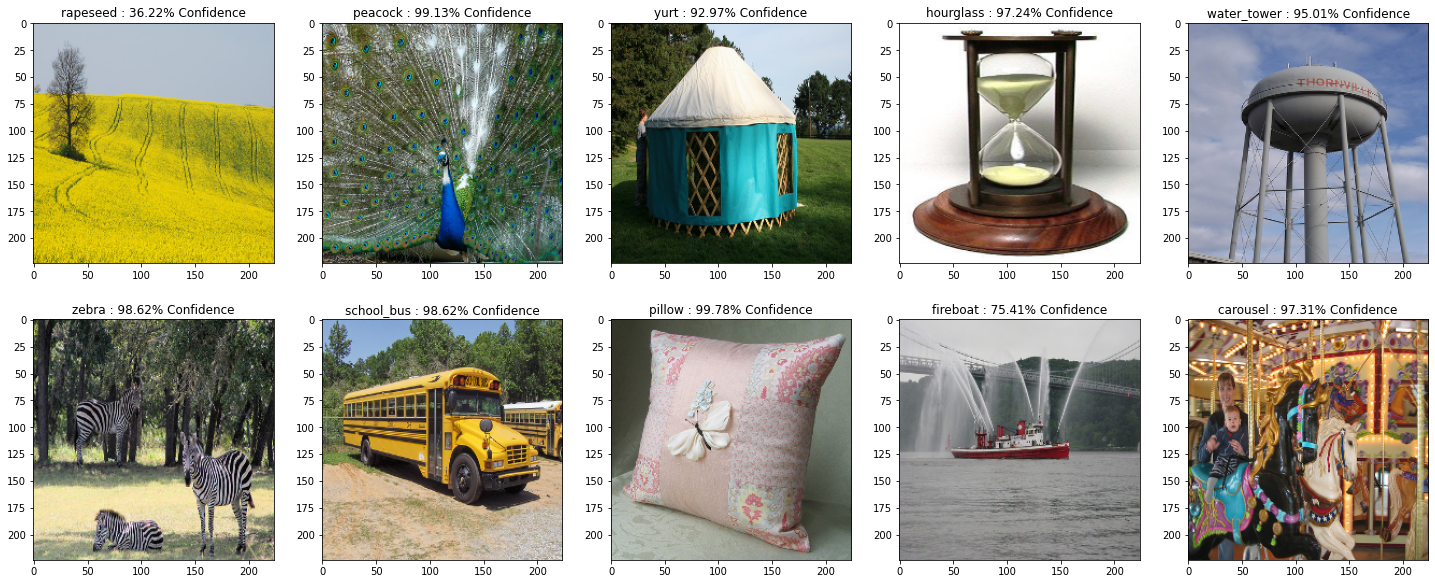

In [ ]:
import os
plt.figure(figsize=(25,10))
fig_path = "/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/"
for i in range(1,11):
  image_raw = tf.io.read_file(os.path.join(fig_path,(str(i)+".png")))
  image = tf.image.decode_image(image_raw,3)
  image = preprocess(image)
  image_probs = pretrained_model.predict(image)
  plt.subplot(2,5,i)
  plt.imshow(image[0])
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.savefig("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/all_images.jpg")

40960/35363 [==================================] - 0s 0us/step


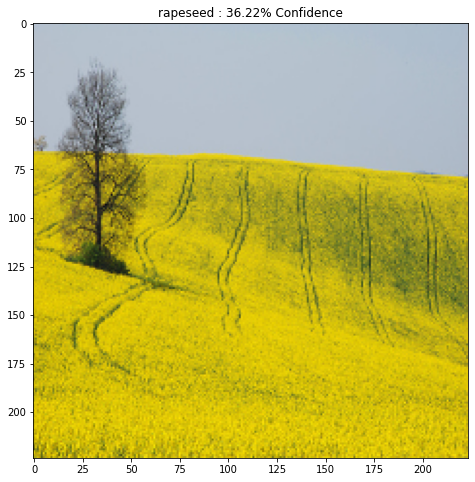

In [ ]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image) 
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad, gradient 

The resulting perturbations can also be visualised.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


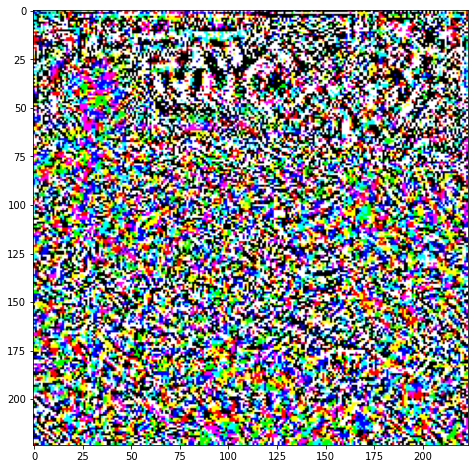

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations , enhance = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])

In [ ]:
perturbations.shape

TensorShape([1, 224, 224, 3])

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [ ]:
def display_images(image, description):
  
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

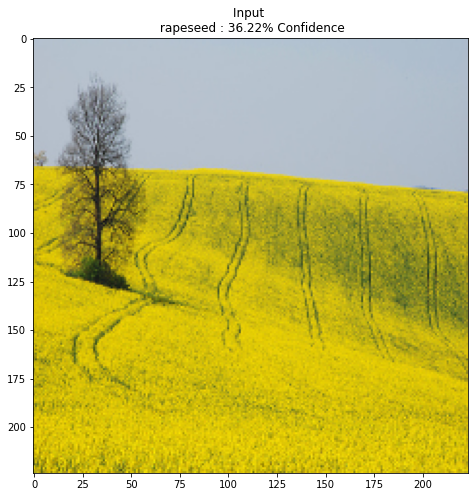

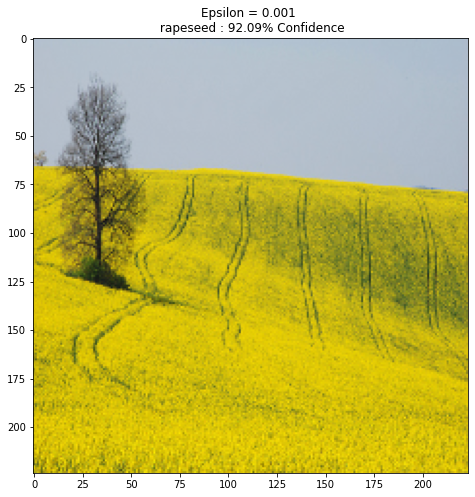

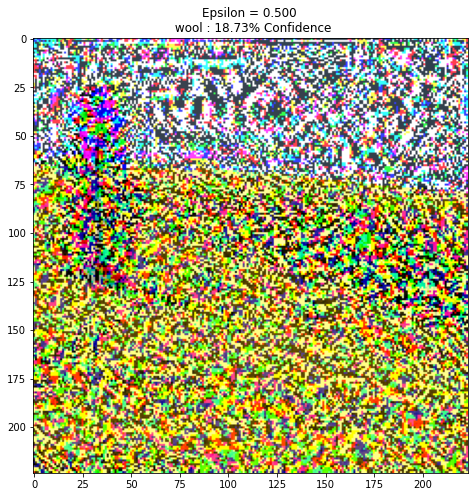

In [ ]:
epsilons = [0, 0.001, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = eps*perturbations + image 
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

We can look at different intensity of perturbation and what model sees


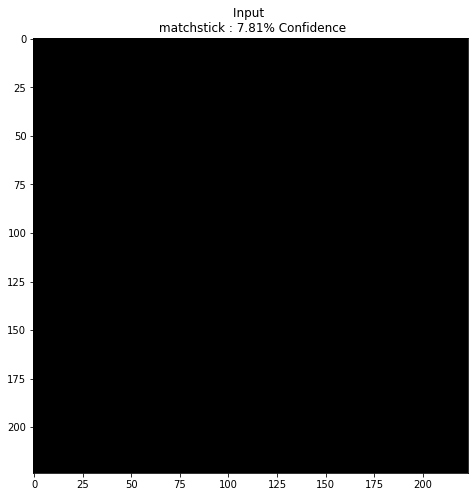

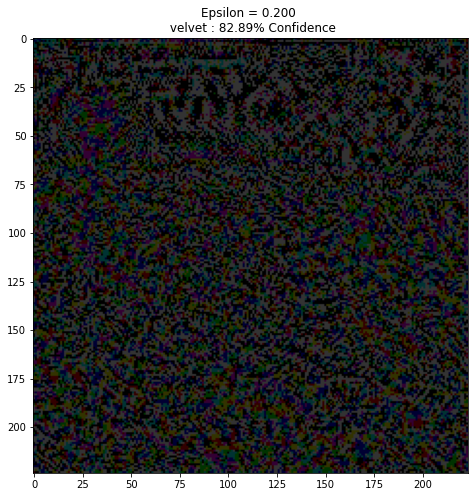

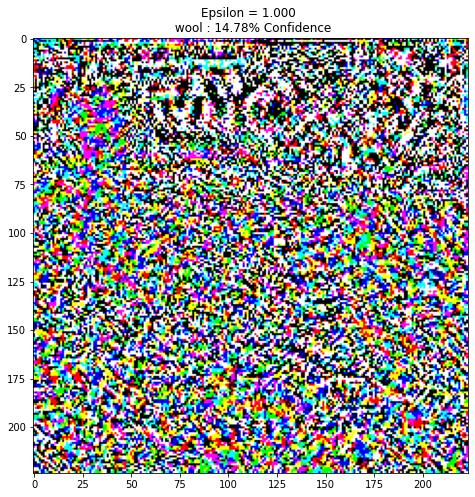

In [ ]:
epsilons = [0, 0.2, 1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = eps*perturbations# + image 
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])

We can also add different noise level to "enhance" the confidence of model.
However, adding too much will hurt more than help

Note that now the noise added is **negative of gradient**.
This is what we usually do for gradient descend

---



Iterative attack:
First, pick a class index.
Then start the attack!

In [ ]:
def display_images_1(image, description, index):
  
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.subplot(3,6,index)
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))

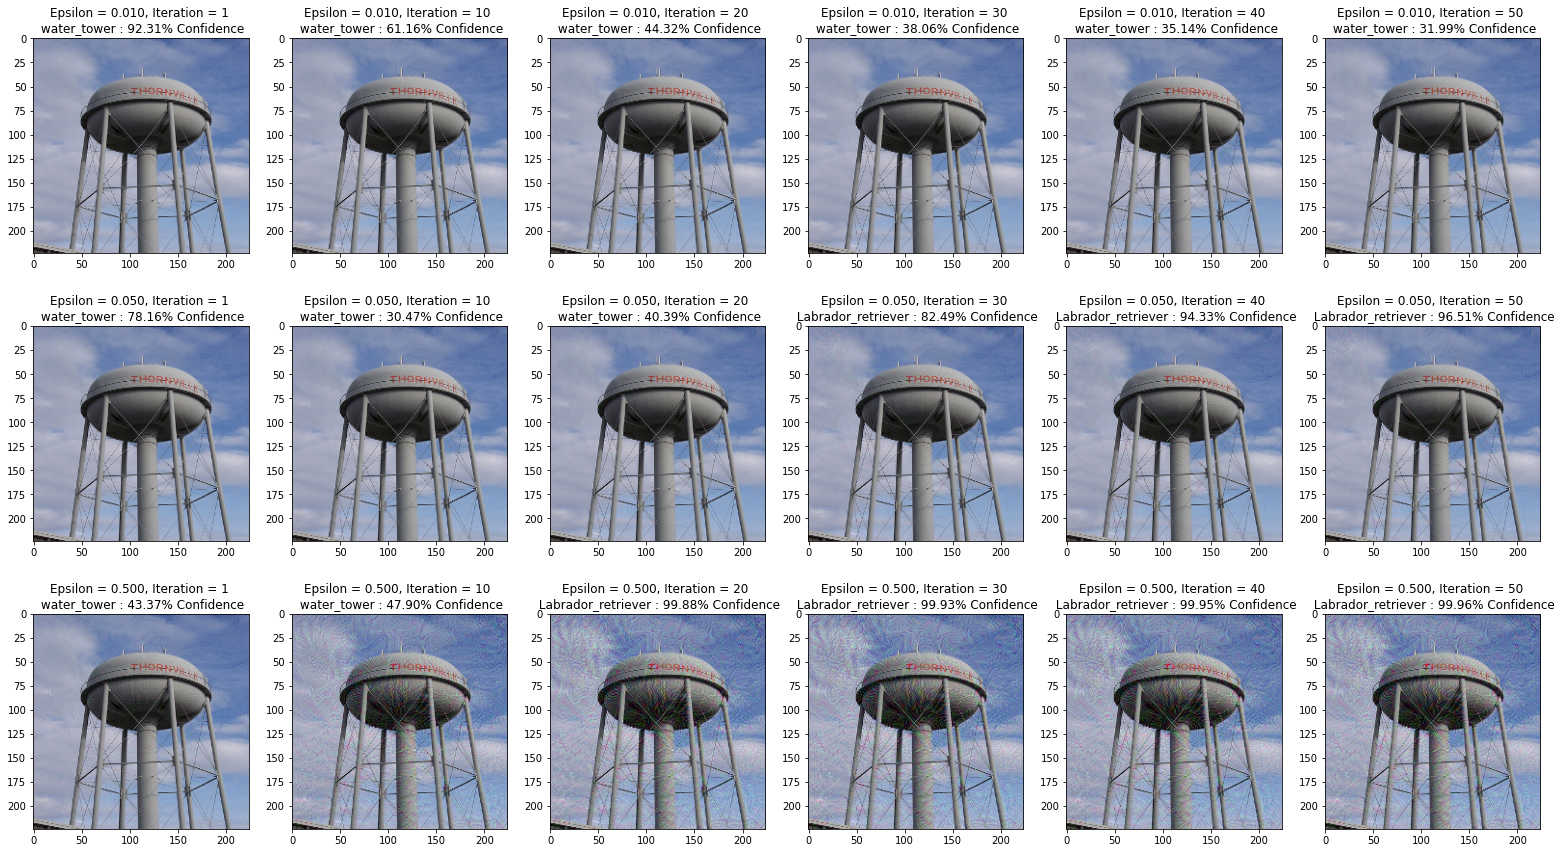

In [ ]:
image_raw = tf.io.read_file("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/5.png")

def adversarial_attack(image_raw, iteration, epsilons):
  row = 0
  for eps in epsilons:
    image = tf.image.decode_image(image_raw,3)
    image = preprocess(image)
    index = 208
    label = tf.one_hot(index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations , enhance = create_adversarial_pattern(image, label)
    accumulated = 0*image #accumulate gradients over the iterations
    for j in range(1, iteration): #Most attacks will start to show result before 100 iterations
      accumulated = eps*enhance + accumulated
      adv_x = eps*enhance + image 
      adv_x = tf.clip_by_value(adv_x, 0, 1)
      if(j==1 or j%10 == 0):
        description = 'Epsilon = {:0.3f}, Iteration = {}'.format(-eps, j)
        display_images_1(adv_x, description, j//10 + 1 + 6*row)
      perturbations , enhance = create_adversarial_pattern(image, label)
      image = adv_x
    row+=1

plt.figure(figsize=(27,15))
adversarial_attack(image_raw, iteration=51, epsilons=[-0.01, -0.05, -0.5])
plt.savefig("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/different_epsilon.jpg")

In [ ]:
image_raw = tf.io.read_file("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/1.png")
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)

index = 208 #Find class index here: https://github.com/USCDataScience/dl4j-kerasimport-examples/blob/master/dl4j-import-example/data/imagenet_class_index.json
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations , enhance = create_adversarial_pattern(image, label)
accumulated = 0*image #accumulate gradients over the iterations
for j in range(20): #Most attacks will start to show result before 100 iterations

  epsilons = [-0.01]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    accumulated = eps*enhance + accumulated
    adv_x = eps*enhance + image 
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, j)
  perturbations , enhance = create_adversarial_pattern(image, label)
  image = adv_x

# 27,15长度

Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


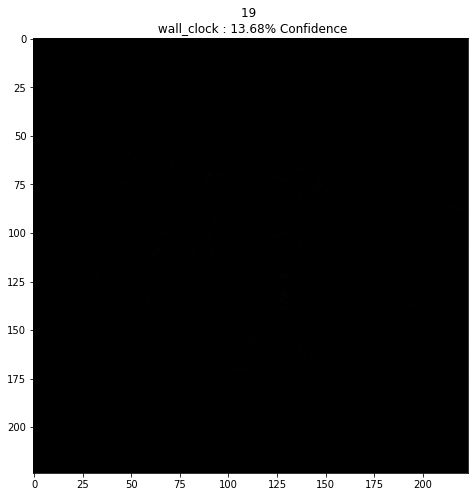

In [ ]:
display_images(accumulated, j)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


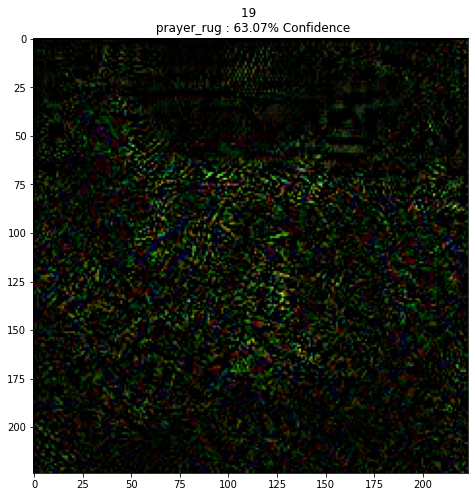

In [ ]:
display_images(accumulated*50, j)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


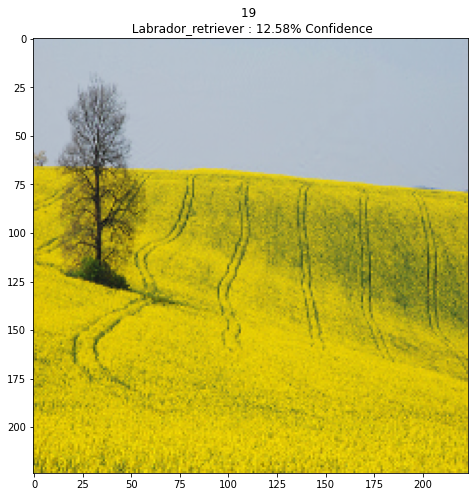

In [ ]:
image_raw = tf.io.read_file("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/1.png")
image = tf.image.decode_image(image_raw,3)

image = preprocess(image)
display_images(accumulated*1+image, j)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


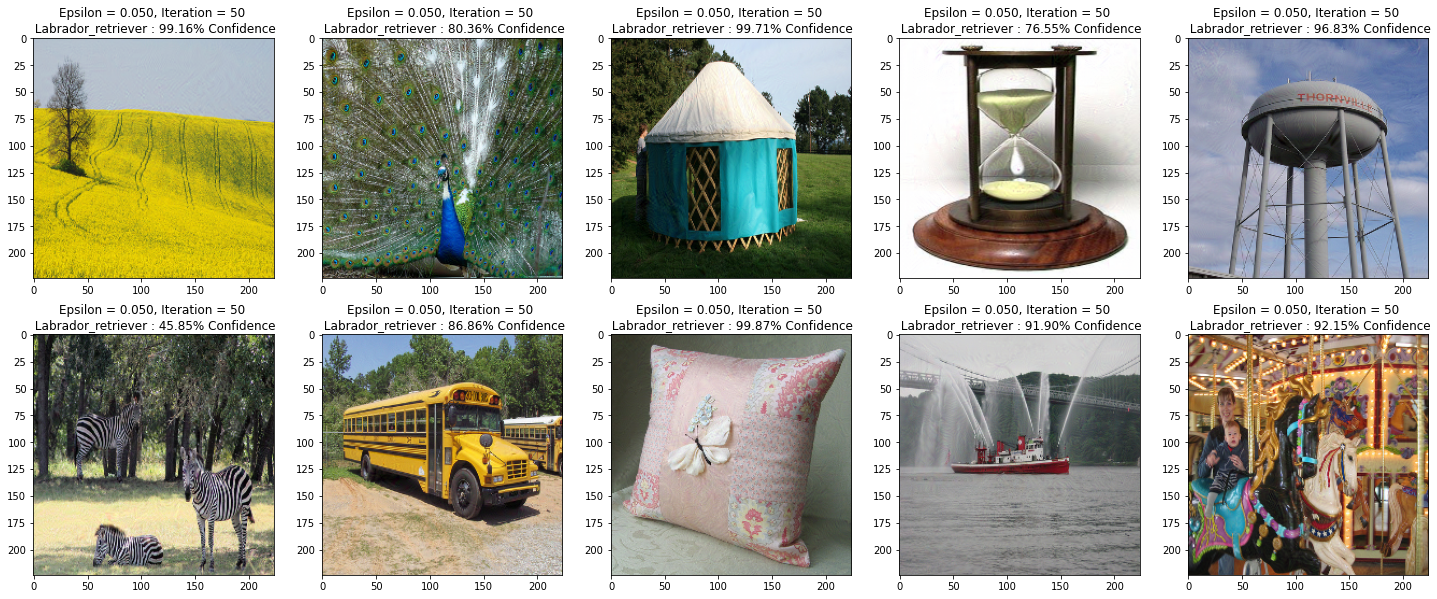

In [ ]:
def display_images(image, description, i):
  
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.subplot(2,5,i)
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))

def adversarial_all(fig_path):
  for i in range(1,11):
    image_raw = tf.io.read_file(os.path.join(fig_path,(str(i)+".png")))
    image = tf.image.decode_image(image_raw,3)
    image = preprocess(image)

    index = 208 #Find class index here: https://github.com/USCDataScience/dl4j-kerasimport-examples/blob/master/dl4j-import-example/data/imagenet_class_index.json
    label = tf.one_hot(index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations , enhance = create_adversarial_pattern(image, label)
    accumulated = 0*image #accumulate gradients over the iterations
    for j in range(1, 51): #Most attacks will start to show result before 100 iterations
      eps = -0.05
      accumulated = eps*enhance + accumulated
      adv_x = eps*enhance + image 
      adv_x = tf.clip_by_value(adv_x, 0, 1)
      perturbations , enhance = create_adversarial_pattern(image, label)
      image = adv_x

    descriptions = 'Epsilon = {:0.3f}, Iteration = {}'.format(-eps, j) 
    image = tf.image.decode_image(image_raw,3)
    image = preprocess(image)
    display_images(accumulated*1+image, descriptions, i)

plt.figure(figsize=(25,10))
fig_path = "/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/images/"
adversarial_all(fig_path)
plt.savefig("/content/drive/My Drive/Colab Notebooks/pytorch_learn/5012_pytorch_tutorial/Adversarial Attack/adversarial_all.jpg")

This approach is not an Universial attack.

Some fast exercises:

1. Try create Universial attack  
2. Test transferability of attack on different models. 
3. Plot and analyze accuracy lost among different models per iteration


